In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import colormaps, misc

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

In [2]:
# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model

def generate_images_from_models(image_indices, model_paths):
    all_model_outputs = {}
    
    for model_path in model_paths:
        model_name = model_path.split("/")[-1]
        pipeline, datamanager, model = load_model(Path(model_path))
        
        model_outputs = {}
        
        for idx in image_indices:
            # Your code to produce an image would go here.
            model.eval()
            _, ray_bundle, batch = datamanager.next_eval_image(idx)
            H, W = model.metadata["image_height"], model.metadata["image_width"]

            # High res image:
            H = 64
            W = H * 2
            cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
            cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
            fx = torch.tensor(H, dtype=torch.float32).repeat(1)
            fy = torch.tensor(H, dtype=torch.float32).repeat(1)

            c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

            cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

            ray_bundle = cameras.generate_rays(0).flatten().to(device)
            ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

            batch['image'] = batch['image'].to(device)

            # check if the model has attribute old_implementation
            if hasattr(model.field, 'old_implementation'):
                if model.field.old_implementation:
                    get_rotation = rot_y
                else:
                    get_rotation = rot_z

            rotation = get_rotation(torch.tensor(np.deg2rad(0.0)).float())
            rotation = rotation.to(device)

            outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle)

            pred_img = model.field.unnormalise(outputs['rgb'])
            gt_image = model.field.unnormalise(batch['image'])

            # converting to grayscale by taking the mean across the color dimension
            gt_image_gray = torch.mean(gt_image, dim=-1)
            pred_image_gray = torch.mean(pred_img, dim=-1)

            # reshape to H, W
            gt_image_gray = gt_image_gray.reshape(H, W, 1)
            pred_image_gray = pred_image_gray.reshape(H, W, 1)

            gt_min, gt_max = torch.min(gt_image_gray), torch.max(gt_image_gray)

            combined_log_heatmap = torch.cat([gt_image_gray, pred_image_gray], dim=1)

            combined_log_heatmap = colormaps.apply_depth_colormap(
                combined_log_heatmap,
                near_plane=gt_min,
                far_plane=gt_max,
            )

            outputs['rgb'] = outputs['rgb'].reshape(H, W, 3)
            pred_img = model.field.unnormalise(outputs['rgb'])
            pred_img = linear_to_sRGB(pred_img, use_quantile=True)

            model_outputs[idx] = {'img': pred_img.cpu().detach(),
                                  'combined_log_heatmap': combined_log_heatmap.cpu().detach()}
            
        all_model_outputs[model_name] = model_outputs
    
    return all_model_outputs

In [3]:
# Example usage
image_indices = [1, 2, 3]
model_paths = [
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_9',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_49',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100',
    '/workspace/outputs/reni/spherical_harmonics/2nd_order',
    '/workspace/outputs/reni/spherical_harmonics/6th_order',
    '/workspace/outputs/reni/spherical_harmonics/9th_order',
    '/workspace/outputs/reni/spherical_gaussians/30_params',
    '/workspace/outputs/reni/spherical_gaussians/150_params',
    '/workspace/outputs/reni/spherical_gaussians/300_params'
]

output_images = generate_images_from_models(image_indices, model_paths)


Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12 │   '/workspace/outputs/reni/spherical_gaussians/300_params'                                │
│   13 ]                                                                                           │
│   14                                                                                             │
│ ❱ 15 output_images = generate_images_from_models(image_indices, model_paths)                     │
│   16                                                                                             │
│                                                                                                  │
│ in generate_images_from_models:140                                                               │
│                                                                                                  │
│   137 │   │   │   pred_image_gray = torch.mean(pred_img, dim=-1)                                 │
│   138 │   │   │                                                                                  │
│   139 │   │   │   # reshape to H, W                                                              │
│ ❱ 140 │   │   │   gt_image_gray = gt_image_gray.reshape(H, W, 1)                                 │
│   141 │   │   │   pred_image_gray = pred_image_gray.reshape(H, W, 1)                             │
│   142 │   │   │                                                                                  │
│   143 │   │   │   gt_min, gt_max = torch.min(gt_image_gray), torch.max(gt_image_gray)            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: shape '[128, 256, 1]' is invalid for input of size 8192

In [14]:
output_images['2nd_order'][1].device

device(type='cuda', index=0)

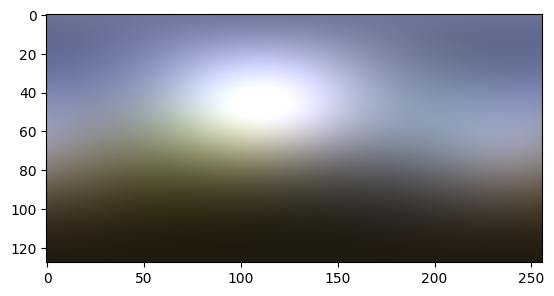

In [13]:
plt.imshow(output_images['2nd_order'][3].cpu().detach().numpy())